In [55]:
import pystan
import stan_utility

import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import scipy.stats as stats
import seaborn as sb
import pandas as pd

dark = "#EECA02"
dark_highlight = "#BB9700"


In [62]:
FatalAccidents = [24,25,31,31,22,21,26,20,16,22]
PassengerDeaths = [734,516,754,877,814,362,764,809,223,1066]
DeathRate = [0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]
MilesFlown = [3863.0,4300.0,5027.0,5481.0,5814.0,6033.0,5877.0,6223.0,7433.0,7107.0]

AccidentsData = pd.DataFrame({'Year': [1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
                              'Fatal accidents': FatalAccidents,
                              'Passenger deaths': PassengerDeaths,
                              'Death rate': DeathRate,
                              'Miles flown [100 mln miles]': MilesFlown}).set_index('Year')

acc=[]
data_cnt=[]
for i in AccidentsData['Fatal accidents']:  
    data_cnt.append(-(1.+acc.count(i)))
    acc.append(i)
data_cnt=np.array(data_cnt)

AccidentsData

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


In [16]:
#We assume death rate is constant and doesn't deppend on anything
#getting lambda upper bound
root_of_lam = np.polynomial.polynomial.polyroots([-365.,3.,1.])
lam_ub = np.round(root_of_lam[root_of_lam>0]**2)
print(lam_ub)

[312.]


In [2]:
#prior tuning
#i will use half normal distribution to find sigma

with open('Prior.stan', 'r') as file:
    print(file.read())

functions{
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i){
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
    return deltas;
  }
  data{
    vector[1] y_guess;
    vector[1] theta;
  }
  transformed data{
    vector[1] y;
    real x_r[0];
    int x_i[0];

    y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);

    print("Standard deviation = ", exp(y[1]));
  }
  generated quantities{
    real sigma = exp(y[1]);
  }
}



In [10]:
tuning = stan_utility.compile_model('Prior.stan')

Using cached StanModel


In [17]:
data = dict(y_guess = np.array([np.log(100)]), theta = np.array(lam_ub))
tuned = tuning.sampling(data = data,
                       seed = 20062020,
                       algorithm = "Fixed_param",
                       iter = 1,
                       warmup =0,
                       chains = 1)
sigma = np.round(tuned.extract()['sigma'][0])
print(sigma)

121.0


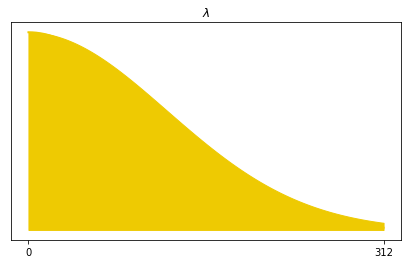

In [27]:
fig, ax2 = plt.subplots(1,1,figsize=(7,4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,lam_ub[0],1000)
ax2.plot(x4,2*stats.norm.pdf(x2,scale=sigma), color=dark, linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0, color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,lam_ub[0]])
ax2.set_title(r'$\lambda$')
plt.show()

In [23]:
with open('hnorm_PPC.stan', 'r') as file:
    print(file.read())

data {
  int M; //number of years analyzed
}

generated quantities {
  real lambda = fabs(normal_rng(0,121));
  int y_sim[M];
  for (i in 1:M) {
    y_sim[i] = poisson_rng(lambda);
  }
}



In [30]:
model_prior=stan_utility.compile_model('hnorm_PPC.stan')

Using cached StanModel


In [31]:
sim_uf = model_prior.sampling(data={'M':1},
                             algorithm="Fixed_param",
                             iter=1000,
                             warmup=0,
                             chains=1,
                             refresh=1000,
                             seed=20062020)

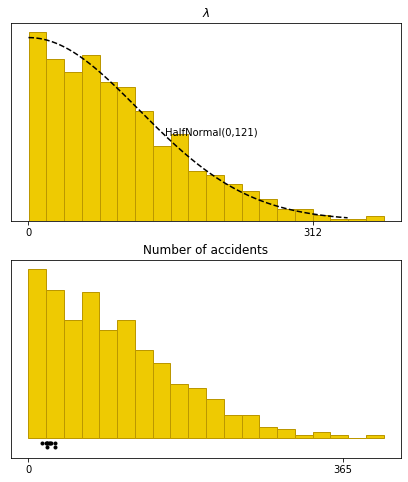

In [63]:
params=sim_uf.extract()
theta=params['lambda']
y_sim=params['y_sim']

fig, axes = plt.subplots(2,1,figsize=(7,8))
ax1=axes[0]
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight, density=True)
x=np.linspace(0,350,2000)
ax1.set_xticks([0,lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma), color='black', linestyle='--')
arr_y_loc = 2*stats.norm.pdf(150,0,sigma)
ax1.annotate('HalfNormal(0,'+str(np.int(sigma))+')', xy=(150,arr_y_loc))
ax2=axes[1]
ax2.hist(y_sim.flatten(), color=dark, edgecolor=dark_highlight, density=True, bins=20)
ax2.scatter(acc,0.0002*data_cnt,color='black', marker='.',zorder=2)
ax2.set_xticks([0,365])
ax2.set_yticks([])
ax2.set_title('Number of accidents')

plt.show()

#out model seems to be reasonable with data

In [65]:
#Posterior interference and posterior predictive checks
with open('PosteriorPredictiveCheck.stan', 'r') as file:
    print(file.read())

data{
  int M; //number of years analyzed
  int y[M]; //number of fatal accidents
}
parameters{
  real<lower=0>lambda;
}
model{
  lambda ~ normal(0,121);
  for(i in 1:M){
    y[i] ~ poisson(lambda);
  }
}
generated quantities{
  int y_sim[M];
  for(i in 1:M){
    y_sim[i] = poisson_rng(lambda);
  }
}



In [67]:
model = stan_utility.compile_model('PosteriorPredictiveCheck.stan')

Using cached StanModel


In [77]:
data = dict(M = len(AccidentsData),
           y = AccidentsData['Fatal accidents'])
fit = model.sampling(data=data, seed=20062020)

params=fit.extract()
lam=params['lambda']
y_sim=params['y_sim']

In [69]:
mean_lam = np.mean(lam)
cinf_lam = az.hpd(lam,0.89)

hpd_width=cinf_lam[1]-cinf_lam[0]

In [76]:
print('Mean lambda: {:4.2f}'.format(mean_lam))
print('89% confidence interval: [{:4.2f}'.format(cinf_lam[0])+', {:4.2f}'.format(cinf_lam[1])+']')

Mean lambda: 23.89
89% confidence interval: [21.27, 26.12]


In [78]:
median_y_sim = np.median(y_sim.flatten())
cinf_y_sim = az.hpd(y_sim.flatten(),0.89)

print('Mean of predicted accidents =', median_y_sim)
print('Confidence interval = [',*cinf_y_sim,']')

Mean of predicted accidents = 24.0
Confidence interval = [ 15.0 31.0 ]


In [105]:
#Now we consider model in whitch rate is a product of intensity and miles flown

#assigning the prior for theta that would hveprobability of smaller lambda equal 99%

mean_miles=np.mean(AccidentsData['Miles flown [100 mln miles]'])
root_of_theta=np.polynomial.polynomial.polyroots([-365/mean_miles,3./np.sqrt(mean_miles),1.])
theta_ub=(root_of_theta[root_of_lam>0]**2)
print('theta upper bound =','{:4.3f}'.format(theta_ub[0]))

theta upper bound = 0.055


In [107]:
#we're tuning again, but this time for theta, so halfnormal dist will be thinner
data=dict(y_guess=np.array([np.log(0.01)]), theta=np.array(theta_ub))
tuned2 = tuning.sampling(data=data,
                        seed=20062020,
                        algorithm="Fixed_param",
                        iter=1,
                        warmup=0,
                        chains=1)
sigma = (tuned2.extract()['sigma'][0])
print('sigma = {:4.3f}'.format(sigma))

sigma = 0.021


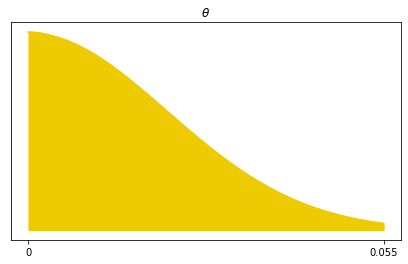

In [110]:
fig, ax2 = plt.subplots(1,1,figsize=(7,4))
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,theta_ub[0],1000)
ax2.plot(x4,2*stats.norm.pdf(x2,scale=sigma), color=dark, linewidth=2)
ax2.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0, color=dark)
ax2.set_yticks([])
ax2.set_xticks([0,theta_ub[0]])
ax2.set_xticklabels([0,0.055])
ax2.set_title(r'$\theta$')
plt.show()

In [111]:
with open('hnorm_PPC_miles.stan', 'r') as file:
    print(file.read())

data {
  int M; //number of years analyzed
  vector[M] miles; //number of miles flown each year
}

generated quantities {
  real theta = fabs(normal_rng(0,0.021));
  int y_sim[M];
  for (i in 1:M) {
    y_sim[i] = poisson_rng(theta*miles[i]);
  }
}



In [116]:
model_prior=stan_utility.compile_model('hnorm_PPC_miles.stan')

Using cached StanModel


In [117]:
data_prior=dict(M=len(AccidentsData), miles=AccidentsData['Miles flown [100 mln miles]'])
sim_uf = model_prior.sampling(data=data_prior,
                             algorithm="Fixed_param",
                             iter=1000,
                             warmup=0,
                             chains=1,
                             refresh=1000,
                             seed=20062020)

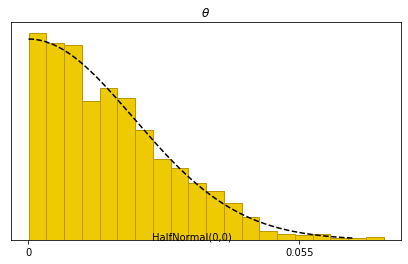

In [129]:
params=sim_uf.extract()
theta=params['theta']

fig, axes = plt.subplots(1,1,figsize=(7,4))
ax1=axes
ax1.hist(theta,bins=20,color=dark,edgecolor=dark_highlight, density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
ax1.set_xticks([0,theta_ub[0]])
ax1.set_xticklabels([0,0.055])
ax1.set_yticks([])
ax1.set_title(r'$\theta$')
ax1.plot(x,2*stats.norm.pdf(x,0,sigma), color='black', linestyle='--')
arr_y_loc = 2*stats.norm.pdf(150,0,sigma)
ax1.annotate('HalfNormal(0,'+str(np.int(sigma))+')', xy=(0.025,arr_y_loc))
plt.show()

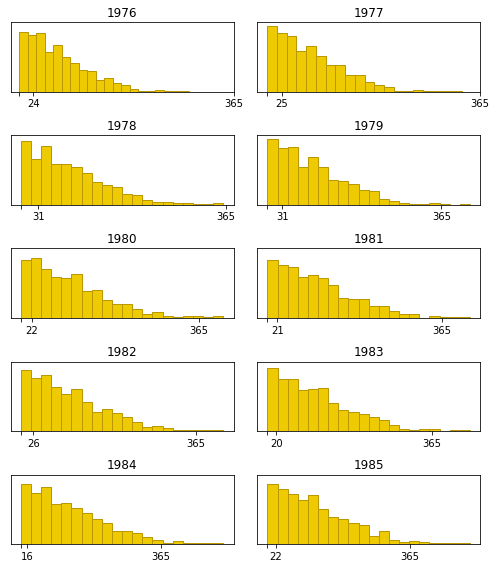

In [135]:
#results are consistent, we can continue

y_sim=params['y_sim']
fig, axes = plt.subplots(5,2,figsize=(7,8),sharey=True, squeeze=False)
axes_flat=axes.flatten()

for i in range(len(axes_flat)):
    ax = axes_flat[i]
    ax.hist(y_sim[:,i], bins=20, color=dark,edgecolor=dark_highlight)
    ax.set_title(AccidentsData.index[i])
    tv=AccidentsData['Fatal accidents'].iloc[i]
    ax.plot([tv,tv], [0,0.02], linestyle='--', color='black')
    ax.set_yticks([])
    ax.set_xticks([0,tv,365])
    ax.set_xticklabels(['',tv,365])

fig.tight_layout()

plt.show()

In [136]:
with open('PosteriorPredictiveCheck_miles.stan', 'r') as file:
    print(file.read())
#this model is very similiar to previous prior predictive check, but with miles

data{
  int M; //number of years analyzed
  vector[M] miles; //number of miles flown each year
  int y[M]; //number of fatal accidents
}
parameters{
  real<lower=0>theta;
}
model{
  theta ~ normal(0,0.021);
  for(i in 1:M){
    y[i] ~ poisson(miles[i]*theta);
  }
}
generated quantities{
  int y_sim[M];
  for(i in 1:M){
    y_sim[i] = poisson_rng(miles[i]*theta);
  }
}



In [141]:
model_miles = stan_utility.compile_model('PosteriorPredictiveCheck_miles.stan')

Using cached StanModel


In [142]:
data = dict(M=len(AccidentsData),
           miles = AccidentsData['Miles flown [100 mln miles]'],
           y = AccidentsData['Fatal accidents'])
fit = model_miles.sampling(data=data, seed = 20062020)

params_miles = fit.extract()
theta = params_miles['theta']
y_sim = params_miles['y_sim']

In [149]:
mean_theta = np.mean(theta)
cinf_theta = az.hpd(theta,0.89)
hpd_width = cinf_theta[1]-cinf_theta[0]

print('Mean theta = {:5.4f}'.format(mean_theta))
print('Confidence interval = [{:5.4f}'.format(cinf_theta[0])+', {:5.4f}'.format(cinf_theta[1])+']')

Mean theta = 0.0042
Confidence interval = [0.0038, 0.0046]


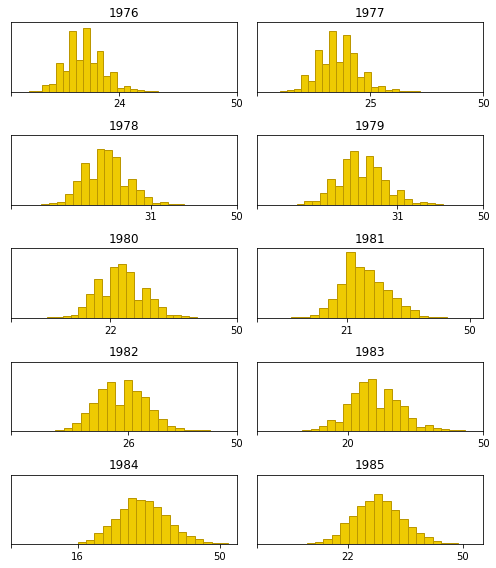

In [151]:
y_sim=params_miles['y_sim']
fig, axes = plt.subplots(5,2,figsize=(7,8),sharey=True, squeeze=False)
axes_flat=axes.flatten()

for i in range(len(axes_flat)):
    ax = axes_flat[i]
    ax.hist(y_sim[:,i], bins=20, color=dark,edgecolor=dark_highlight)
    ax.set_title(AccidentsData.index[i])
    tv=AccidentsData['Fatal accidents'].iloc[i]
    ax.plot([tv,tv], [0,0.15], linestyle='--', color='black')
    ax.set_yticks([])
    ax.set_xticks([0,tv,50])
    ax.set_xticklabels(['',tv,50])

fig.tight_layout()

plt.show()

In [ ]:
#Results even though are inside our field of prediction, thet are located more to the edges of that field.
#We can notice, that in earlier years their vaues are higher than predicted, and in later years lower than predicted.
#This indicates that the is another factor to these statiscics, probably safety regulations, being developed over years.